In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


np.random.seed(42)

In [28]:
train_path_dir = '../../data/wesad_processed/wesad_train_scaled.csv'
test_path_dir = '../../data/wesad_processed/wesad_test_scaled.csv'

train_df = pd.read_csv(train_path_dir)
test_df = pd.read_csv(test_path_dir)

train_df

,chest_acc,chest_ecg,chest_emg,chest_eda,chest_temp,chest_resp,wrist_acc,wrist_bvp,wrist_eda,wrist_temp,label,user_id
0,-1.015142,0.164134,-0.182921,-1.128954,0.111841,0.333043,0.008921,-1.237388,-0.625380,0.172667,0,S10
1,-1.141428,-0.110748,1.247013,-1.133094,0.119808,0.670006,-0.360401,2.064066,-0.624899,0.159101,0,S10
2,-0.873201,-0.471384,0.178598,-1.128283,0.127798,1.059711,0.133037,0.270872,-0.625380,0.159101,0,S10
3,-1.024166,0.073849,1.101760,-1.132647,0.120953,1.350210,-0.285414,-0.193043,-0.624419,0.159101,0,S10
4,-0.585397,-0.894447,0.985558,-1.133766,0.115275,1.304166,-0.105153,0.251581,-0.625860,0.159101,0,S10
...,...,...,...,...,...,...,...,...,...,...,...,...
92751,-0.462146,-0.401405,-0.134503,-0.448654,0.848548,-0.489062,-0.099613,-0.206670,-0.617593,-1.319578,2,S9
92752,-0.144788,0.303085,-0.763932,-0.450668,0.834674,-0.343812,-0.099613,0.170740,-0.619034,-1.319578,2,S9
92753,-0.354109,-0.137934,1.353532,-0.446976,0.855485,0.124587,-0.099613,0.060962,-0.617113,-1.319578,2,S9
92754,-0.452240,2.057093,-0.124820,-0.454025,0.853173,0.692191,-0.099613,-0.317979,-0.617593,-1.319578,2,S9


In [4]:
print('### Train dataset')
for label in train_df['label'].unique():
    t = np.sum(train_df['label'] == 0)
    print(f'label {label} has {t}')

print()
print('### Test dataset')
for label in test_df['label'].unique():
    t = np.sum(test_df['label'] == 0)
    print(f'label {label} has {t}')


### Train dataset
label 0 has 49296
label 1 has 49296
label 2 has 49296

### Test dataset
label 0 has 21148
label 1 has 21148
label 2 has 21148


<AxesSubplot:ylabel='label'>

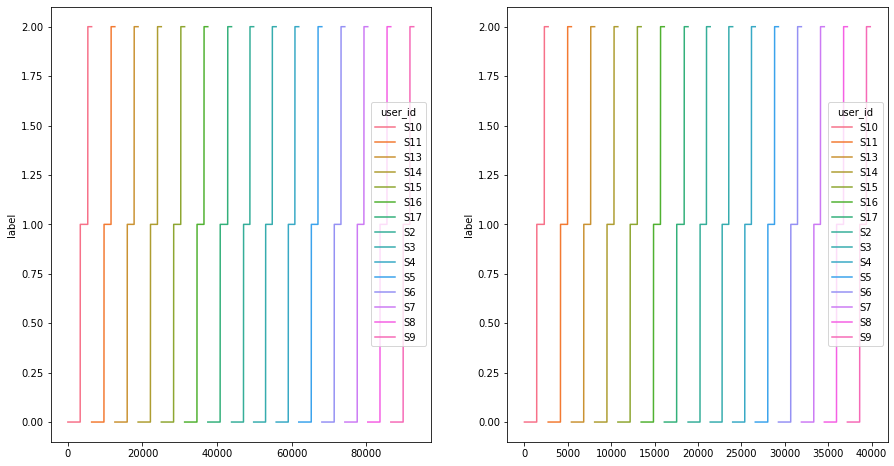

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
sns.lineplot(x = train_df.index, y = train_df['label'], hue=train_df['user_id'], ax=ax1)
sns.lineplot(x = test_df.index, y = test_df['label'], hue=test_df['user_id'], ax=ax2)

In [6]:
train_df.columns

Index(['chest_acc', 'chest_ecg', 'chest_emg', 'chest_eda', 'chest_temp',
       'chest_resp', 'wrist_acc', 'wrist_bvp', 'wrist_eda', 'wrist_temp',
       'label', 'user_id'],
      dtype='object')

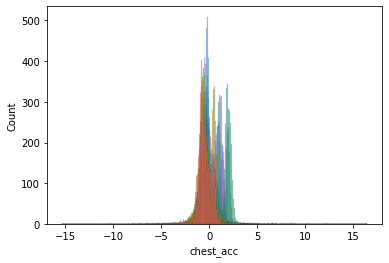

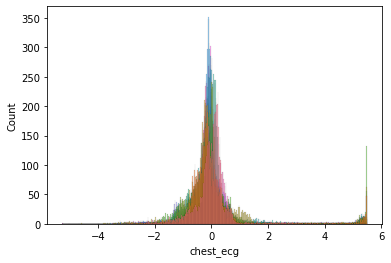

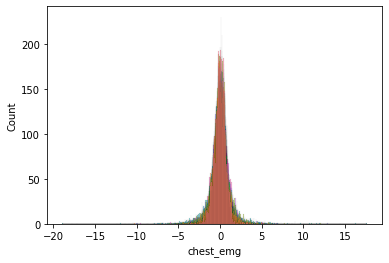

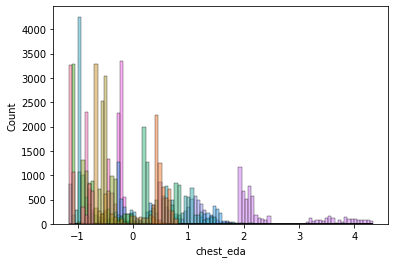

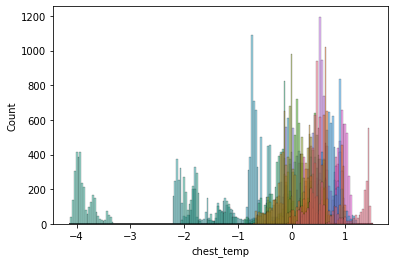

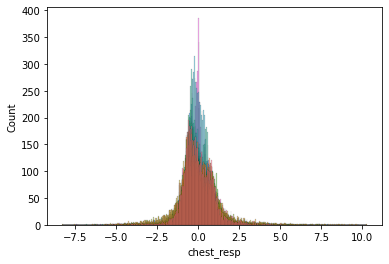

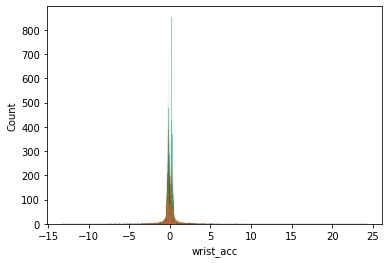

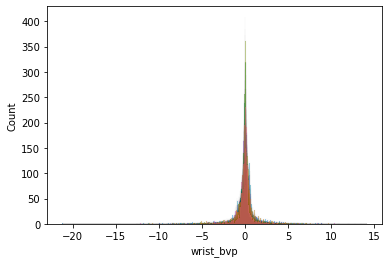

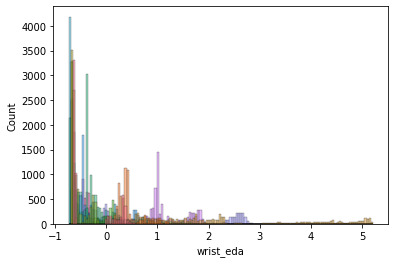

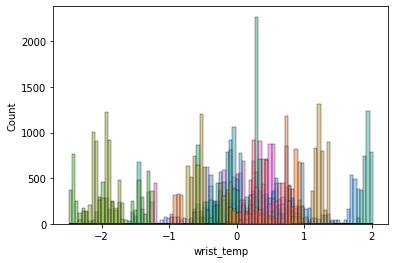

In [7]:
cols = ['chest_acc', 'chest_ecg', 'chest_emg', 'chest_eda', 'chest_temp',
       'chest_resp', 'wrist_acc', 'wrist_bvp', 'wrist_eda', 'wrist_temp',]

for i in range(len(cols)):
    sns.histplot(x=train_df[cols[i]], hue=train_df['user_id'], legend=False)
    plt.show()

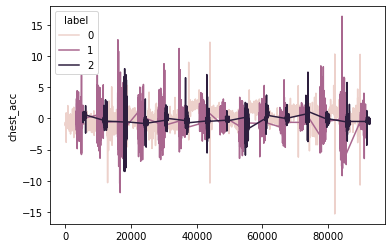

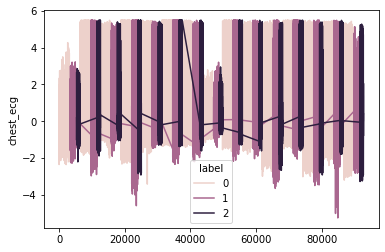

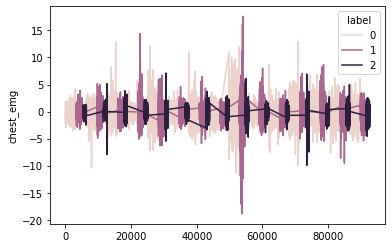

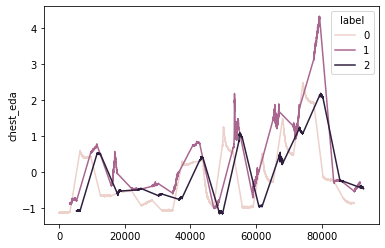

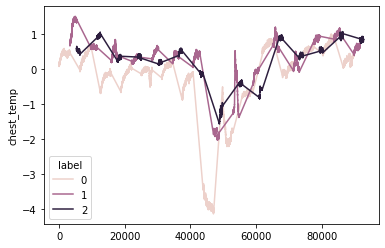

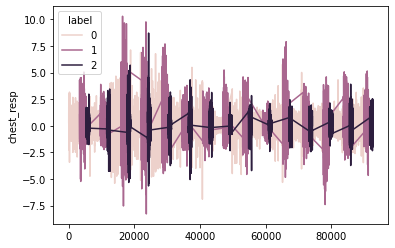

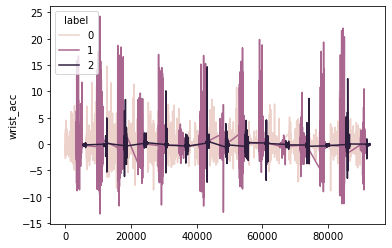

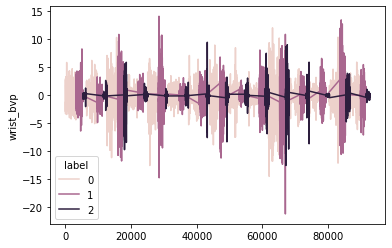

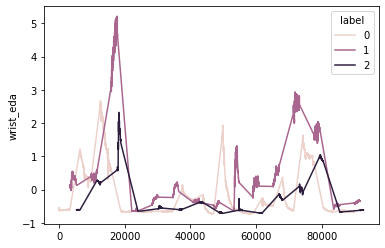

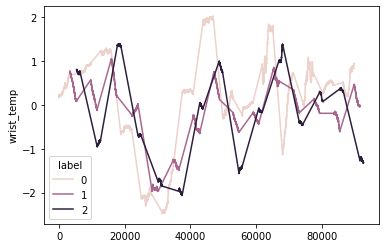

In [16]:
for i in range(len(cols)):
    sns.lineplot(x=train_df.index, y = train_df[cols[i]], hue=train_df['label'], legend=True)
    plt.show()

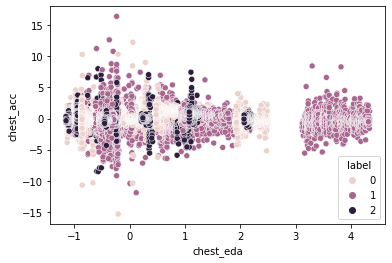

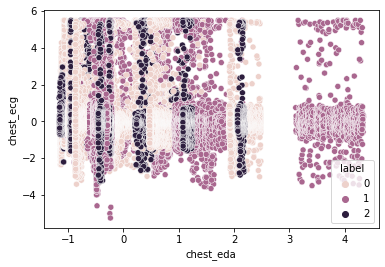

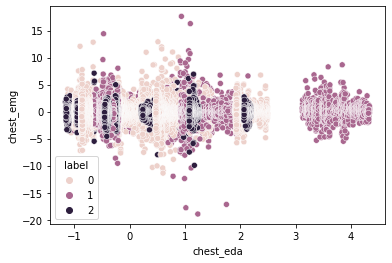

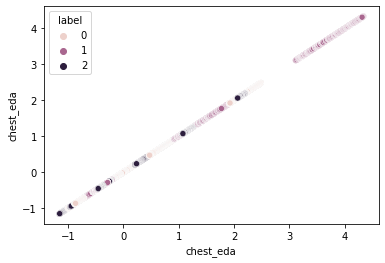

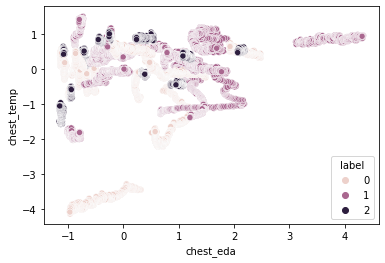

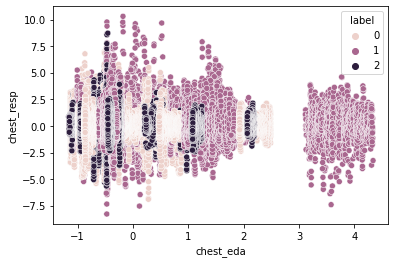

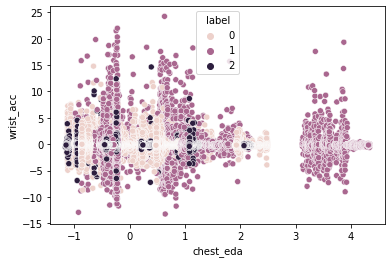

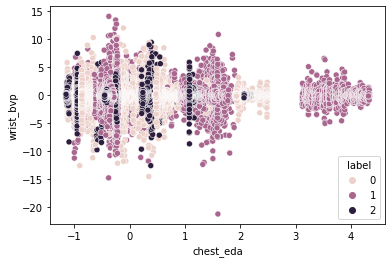

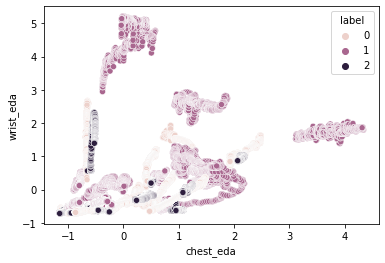

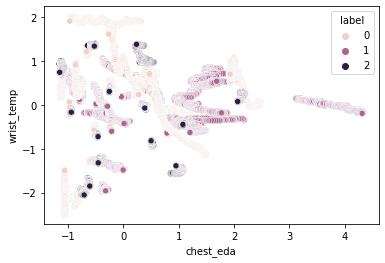

In [19]:
for i in range(len(cols)):
    sns.scatterplot(x=train_df['chest_eda'], y = train_df[cols[i]], hue=train_df['label'], legend=True)
    plt.show()

In [40]:
kmeans = KMeans(3)

X = train_df.drop(['label', 'user_id'], axis=1)[train_df['user_id'] == 'S10']
kmeans.fit(X)

KMeans(n_clusters=3)

In [43]:
X['cluser_labels'] = kmeans.labels_
X['labels'] = train_df[train_df['user_id'] == 'S10']['label']

np.sum(X['cluser_labels'] == X['labels']) / len(X)

0.25251098556183305

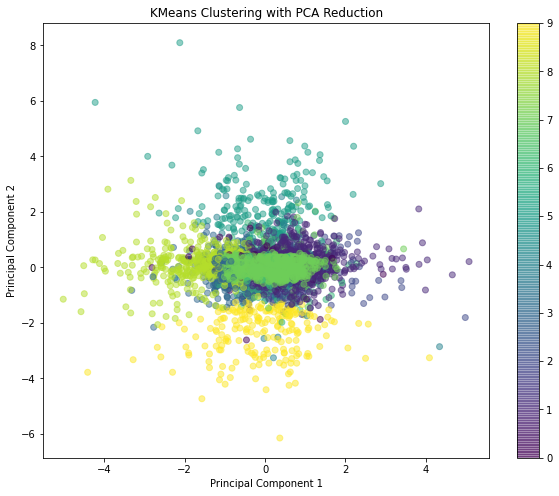

In [31]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualizing in a 2D plot
X_pca = pca.fit_transform(X)

# Assign clusters from KMeans to use as labels for coloring
clusters = kmeans.labels_

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('KMeans Clustering with PCA Reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()